In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Set the max_columns option to None to display all columns
pd.set_option('display.max_columns', None)

In [2]:
df_one = pd.read_excel('/Users/natebender/Documents/ArcGIS/Projects/Western_protected_lands/geodf_growthrate_WGS84_SummarizeWithin_TableToExcel.xlsx')

# counties designation source: 
# https://www.ers.usda.gov/data-products/rural-urban-continuum-codes/documentation/
counties_designation = pd.read_excel('/Users/natebender/Documents/ArcGIS/Projects/Western_protected_lands/ruralurbancodes2013.xls')

In [3]:
# Add in the granular metro / nonmetro designations and update w new columns to just track metro / nonmetro
# at a broader level

df = df_one.merge(counties_designation[['FIPS','RUCC_2013', 'Description']], left_on='geofips', right_on='FIPS', how='left', suffixes=('', '_right'))


In [4]:

# Create a dictionary to map the numeric values to their corresponding descriptions
rucc_map = {
    1: 'metro',
    2: 'metro',
    3: 'metro',
    4: 'nonmetro',
    5: 'nonmetro',
    6: 'nonmetro',
    7: 'nonmetro',
    8: 'nonmetro',
    9: 'nonmetro'
}

# Function to map values to descriptions
def map_rucc_desc(value):
    return rucc_map.get(value, 'Unknown')

# Apply the function to create the "rucc_desc" column
df['rucc_broad'] = df['RUCC_2013'].apply(map_rucc_desc)  # Replace 'Your_Column_Name_Here' with the actual column name


In [5]:
df.sort_values(by='avg_gr_20y', ascending=False).head(2)

,OBJECTID,region,division,state,county,stname,ctyname,geofips,yr_2001,yr_2002,yr_2003,yr_2004,yr_2005,yr_2006,yr_2007,yr_2008,yr_2009,yr_2010,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015,yr_2016,yr_2017,yr_2018,yr_2019,yr_2020,yr_2021,descriptio,linecode,avg_gr_5y,avg_gr_10y,avg_gr_20y,Shape_Length,Shape_Area,protected_overlap_area,Count of Polygons,protected_ratio,FIPS,RUCC_2013,Description,rucc_broad
250,251,4,8,32,29,Nevada,Storey County,32029,0,0.082666,0.002611,0.053856,0.066756,0.100773,0.233908,0.007865,0.030888,0.018234,0.073706,0.100760,0.121127,0.174350,0.114582,0.191255,0.364205,0.334679,0.000328,0.016051,0.072706,ann_growthrate,40,0.157594,0.149004,0.108065,192122.401525,1.151173e+09,0.000000e+00,0,0.000000,32029,2.0,"Metro - Counties in metro areas of 250,000 to ...",metro
311,312,4,9,41,49,Oregon,Morrow County,41049,0,-0.018970,-0.005736,-0.006386,0.045302,0.005501,0.060475,0.005011,0.032978,0.006456,0.034355,0.011055,0.045481,0.078003,0.028690,-0.003531,0.033108,0.036403,-0.048017,-0.040913,0.021882,ann_growthrate,40,0.000492,0.016216,0.016057,482143.177260,1.076371e+10,1.109377e+08,10,0.010307,41049,6.0,"Nonmetro - Urban population of 2,500 to 19,999...",nonmetro


## Compare Metro v Nonmetro

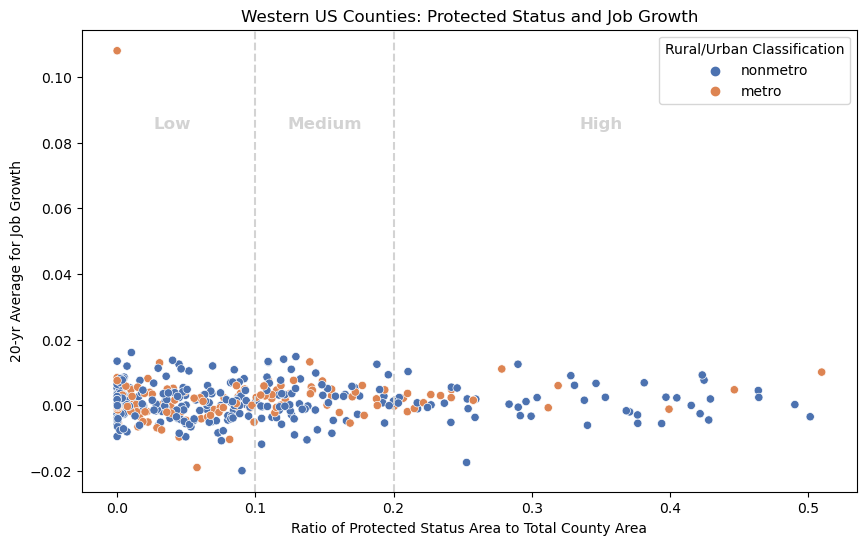

In [6]:
# Create a scatterplot
# Define custom colors for "metro" and "nonmetro"
custom_palette = {"metro": sns.color_palette("deep")[1],  # Orange
                  "nonmetro": sns.color_palette("deep")[0]}  # Blue

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
scatterplot = sns.scatterplot(data=df, x="protected_ratio", y="avg_gr_20y", hue="rucc_broad", palette=custom_palette, markers="o")


# palette={"metro": "lightblue", "nonmetro": "blue"}

# Set labels and a legend
plt.title("Western US Counties: Protected Status and Job Growth")
plt.xlabel("Ratio of Protected Status Area to Total County Area")
plt.ylabel("20-yr Average for Job Growth")
plt.legend(title="Rural/Urban Classification")

# Create vertical dashed lines at the boundaries of the three protected area groups
plt.axvline(0.10, color="lightgrey", linestyle="--")
plt.axvline(0.20, color="lightgrey", linestyle="--")

# group annotations
annotations = [("Low", (0.04, .08)), ("Medium", (0.15, .08)), ("High", (0.35, .08))]
for label, pos in annotations:
    plt.annotate(label, pos, textcoords="offset points", xytext=(0, 10), ha='center', fontsize=12, color="lightgrey", fontweight='bold')

# Update the legend labels
#legend_labels = ["Metro", "Non-Metro"]

# Show the plot
plt.legend(title="Rural/Urban Classification")
plt.show()

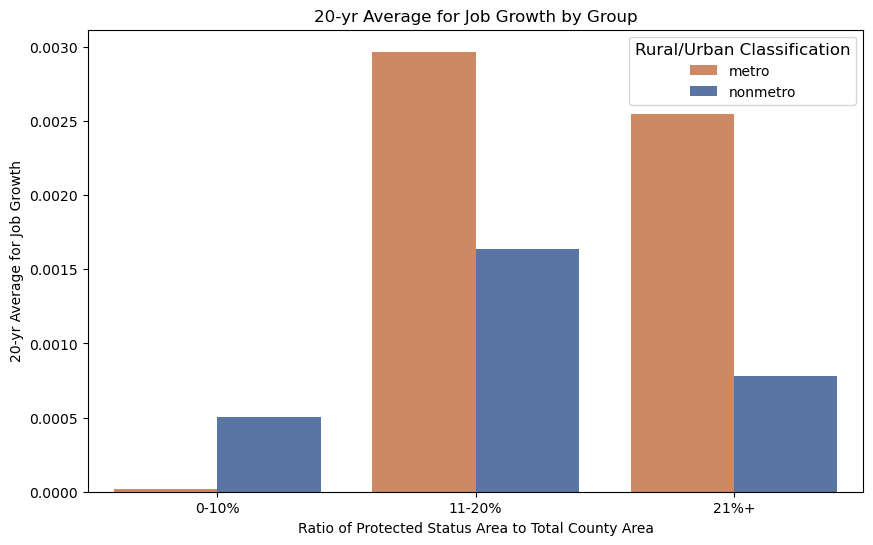

<Figure size 800x600 with 0 Axes>

In [7]:
# Create the "group" column for both "metro" and "nonmetro" counties
df['group'] = pd.cut(df['protected_ratio'], bins=[0, 0.10, 0.20, 1.0], labels=["0-10%", "11-20%", "21%+"])

# Calculate the average-of-averages for each group
group_avg_of_avgs = df.groupby(['rucc_broad', 'group']).agg({'avg_gr_20y': 'mean'}).reset_index()

custom_palette = {"metro": sns.color_palette("deep")[1],  # Orange
                  "nonmetro": sns.color_palette("deep")[0]}  # Blue
# Define the color palette
#colors = {'metro': 'lightblue', 'nonmetro': 'darkblue', 'Overall': 'gray'}

# Create the bar chart to compare "metro" and "nonmetro" groups side by side with an overall bar
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.barplot(data=group_avg_of_avgs, x='group', y='avg_gr_20y', hue='rucc_broad', palette=custom_palette)

# Set labels and a title
plt.title("20-yr Average for Job Growth by Group")
plt.xlabel("Ratio of Protected Status Area to Total County Area")
plt.ylabel("20-yr Average for Job Growth")
plt.legend(title="Rural/Urban Classification", title_fontsize="12")

# Show the plot
plt.show()

# Save the plot to a file (e.g., PNG, JPEG, PDF)
plt.close('all')
plt.figure(figsize=(8, 6))
# Save the plot using the figure's savefig method
fig = plt.gcf()
fig.savefig('group_avg_histogram.png', format='png', dpi=300, transparent=True)

In [8]:
df.head(1)

,OBJECTID,region,division,state,county,stname,ctyname,geofips,yr_2001,yr_2002,yr_2003,yr_2004,yr_2005,yr_2006,yr_2007,yr_2008,yr_2009,yr_2010,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015,yr_2016,yr_2017,yr_2018,yr_2019,yr_2020,yr_2021,descriptio,linecode,avg_gr_5y,avg_gr_10y,avg_gr_20y,Shape_Length,Shape_Area,protected_overlap_area,Count of Polygons,protected_ratio,FIPS,RUCC_2013,Description,rucc_broad,group
0,1,4,8,4,1,Arizona,Apache County,4001,0,0.027246,0.020066,0.030087,0.030314,0.020613,0.06893,-0.005125,-0.011229,-0.027159,-0.011921,-0.012065,-0.022241,0.003471,0.012141,-0.009875,0.001843,0.000972,-0.011801,0.059831,0.006599,ann_growthrate,40,0.011489,0.002888,0.008535,1.216737e+06,4.384223e+10,2.226718e+08,11,0.005079,4001,6.0,"Nonmetro - Urban population of 2,500 to 19,999...",nonmetro,0-10%


In [9]:
metro_df = df[df['rucc_broad'] == 'metro']
nonmetro_df = df[df['rucc_broad'] == 'nonmetro']


metro_avg = metro_df.groupby('group').agg({'avg_gr_20y': 'mean'})
nonmetro_avg = nonmetro_df.groupby('group').agg({'avg_gr_20y': 'mean'})

# Rename the 'avg_gr_20y' column to differentiate metro and nonmetro
metro_avg.rename(columns={'avg_gr_20y': 'avg_gr_20y_metro'}, inplace=True)
nonmetro_avg.rename(columns={'avg_gr_20y': 'avg_gr_20y_nonmetro'}, inplace=True)

# Merge the two DataFrames on the 'group' column
combined_avg = metro_avg.merge(nonmetro_avg, on='group')

print(combined_avg)

        avg_gr_20y_metro  avg_gr_20y_nonmetro
group                                        
0-10%           0.000018             0.000502
11-20%          0.002968             0.001634
21%+            0.002546             0.000783


## Analysis - all counties

### Metro

In [10]:
def calculate_multiple(group1_avg, group2_avg):
    if group2_avg == 0:
        return "Undefined"
    return group1_avg / group2_avg

"0-10%", "11-20%", "21%+"

# Example usage:
low_group_avg = df[df['group'] == "0-10%"]['avg_gr_20y'].mean()
medium_group_avg = df[df['group'] == "11-20%"]['avg_gr_20y'].mean()
high_group_avg = df[df['group'] == "21%+"]['avg_gr_20y'].mean()

high_vs_med = calculate_multiple(high_group_avg, medium_group_avg)
high_vs_low = calculate_multiple(high_group_avg, low_group_avg)
med_vs_low = calculate_multiple(medium_group_avg, low_group_avg)
med_vs_high = calculate_multiple(medium_group_avg, high_group_avg)

print(f"METRO DATAFRAME")
print(f"Low group avg: {low_group_avg}")
print(f"Med group avg: {medium_group_avg}")
print(f"High group avg: {high_group_avg}")
print()

print(f"The Medium group's average job growth rate is {med_vs_high:.2f} times as large as the High group.")
print(f"The High group's average job growth rate is {high_vs_low:.2f} times as large as the Low group.")
print(f"The Med group's average job growth rate is {med_vs_low:.2f} times as large as the Low group.")


METRO DATAFRAME
Low group avg: 0.0003297253963963963
Med group avg: 0.002097213831578948
High group avg: 0.001290856106060606

The Medium group's average job growth rate is 1.62 times as large as the High group.
The High group's average job growth rate is 3.91 times as large as the Low group.
The Med group's average job growth rate is 6.36 times as large as the Low group.


## Nonmetro

In [11]:
# Example usage:
low_group_avg = nonmetro_df[nonmetro_df['group'] == "0-10%"]['avg_gr_20y'].mean()
medium_group_avg = nonmetro_df[nonmetro_df['group'] == "11-20%"]['avg_gr_20y'].mean()
high_group_avg = nonmetro_df[nonmetro_df['group'] == "21%+"]['avg_gr_20y'].mean()

high_vs_med = calculate_multiple(high_group_avg, medium_group_avg)
high_vs_low = calculate_multiple(high_group_avg, low_group_avg)
med_vs_low = calculate_multiple(medium_group_avg, low_group_avg)
med_vs_high = calculate_multiple(medium_group_avg, high_group_avg)

print(f"NONMETRO DATAFRAME")
print(f"Low group avg: {low_group_avg}")
print(f"Med group avg: {medium_group_avg}")
print(f"High group avg: {high_group_avg}")
print()

print(f"The Medium group's average job growth rate is {med_vs_high:.2f} times as large as the High group.")
print(f"The High group's average job growth rate is {high_vs_low:.2f} times as large as the Low group.")
print(f"The Med group's average job growth rate is {med_vs_low:.2f} times as large as the Low group.")


NONMETRO DATAFRAME
Low group avg: 0.0005017059580419581
Med group avg: 0.001633819564516129
High group avg: 0.0007833012978723404

The Medium group's average job growth rate is 2.09 times as large as the High group.
The High group's average job growth rate is 1.56 times as large as the Low group.
The Med group's average job growth rate is 3.26 times as large as the Low group.


## Scatterplots of metro, nonmetro, and overall dataset

In [12]:
def plot_scatter_and_regression(data):
    # Create a scatterplot
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    sns.scatterplot(data=data, x="protected_ratio", y="avg_gr_20y", hue="group", palette="Set1")

    # Set labels and a legend
    plt.title("Western US Counties: Protected Status and Job Growth")
    plt.xlabel("Protected Ratio")
    plt.ylabel("Average 20-year Growth Rate")
    plt.legend(title="Ratio")

    # Create a linear regression model
    X = data[["protected_ratio"]]
    X = sm.add_constant(X)
    y = data["avg_gr_20y"]
    model = sm.OLS(y, X).fit()

    # Calculate the regression line
    slope, intercept = model.params["protected_ratio"], model.params["const"]
    x_values = np.linspace(data["protected_ratio"].min(), data["protected_ratio"].max())
    y_values = slope * x_values + intercept

    # Add a horizontal line at y=0
    plt.axhline(0, color="grey", linestyle="--", label="Y=0")

    # Plot the regression line
    plt.plot(x_values, y_values, color="black", label="Regression Line")

    # Show the plot
    plt.legend()
    plt.show()

In [13]:
def calc_corrs(data, x_column, y_columns):
    for y_column in y_columns:
        correlation = data[x_column].corr(data[y_column])
        print(f"Correlation with {y_column}:", correlation)

In [14]:
calc_corrs(nonmetro_df, "protected_ratio", ["avg_gr_5y", "avg_gr_10y", "avg_gr_20y"])

Correlation with avg_gr_5y: 0.04785684841255123
Correlation with avg_gr_10y: 0.13200417422252977
Correlation with avg_gr_20y: 0.014560309789513398


/Users/natebender/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


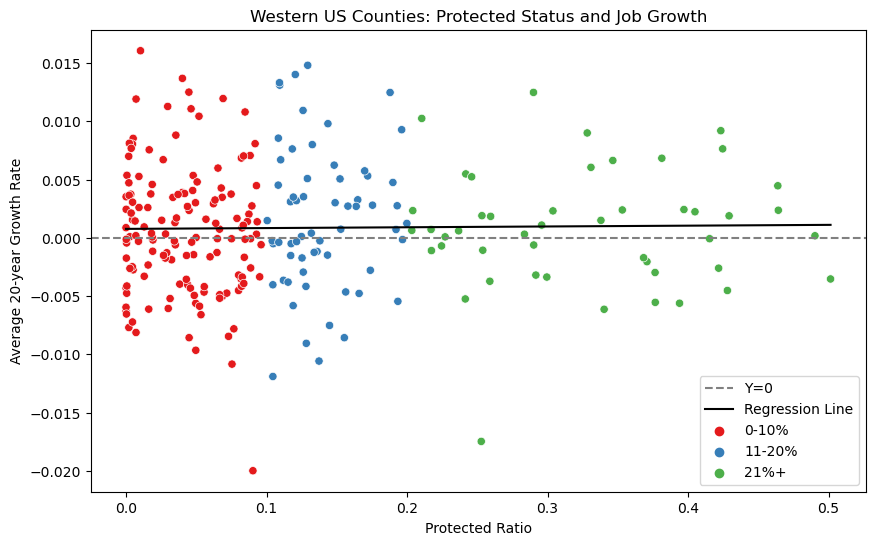

In [15]:
plot_scatter_and_regression(nonmetro_df)

In [16]:
calc_corrs(metro_df, "protected_ratio", ["avg_gr_5y", "avg_gr_10y", "avg_gr_20y"])

Correlation with avg_gr_5y: 0.005430772057271286
Correlation with avg_gr_10y: 0.000935690167775084
Correlation with avg_gr_20y: 0.021681269157390243


/Users/natebender/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


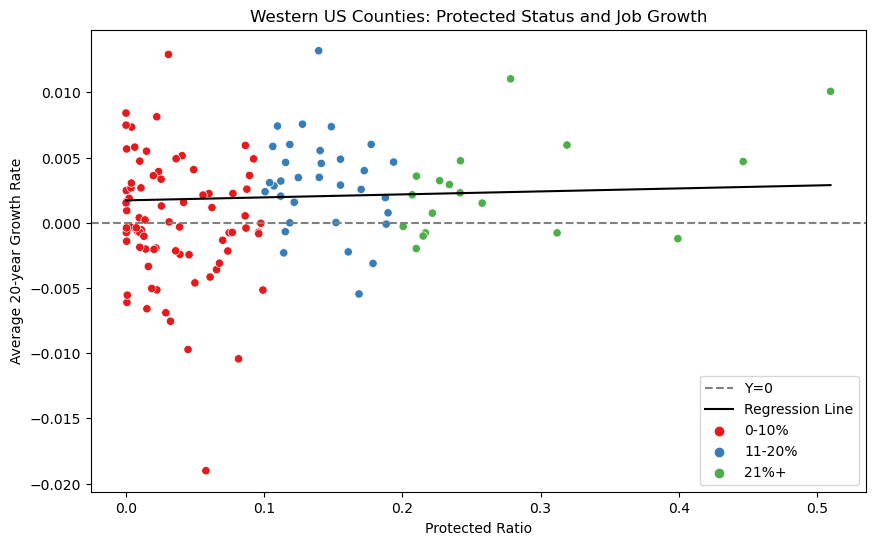

In [17]:
plot_scatter_and_regression(metro_df)

In [18]:
calc_corrs(df, "protected_ratio", ["avg_gr_5y", "avg_gr_10y", "avg_gr_20y"])

Correlation with avg_gr_5y: 0.0216015592622159
Correlation with avg_gr_10y: 0.05732587637375164
Correlation with avg_gr_20y: 0.0117692406790924


/Users/natebender/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


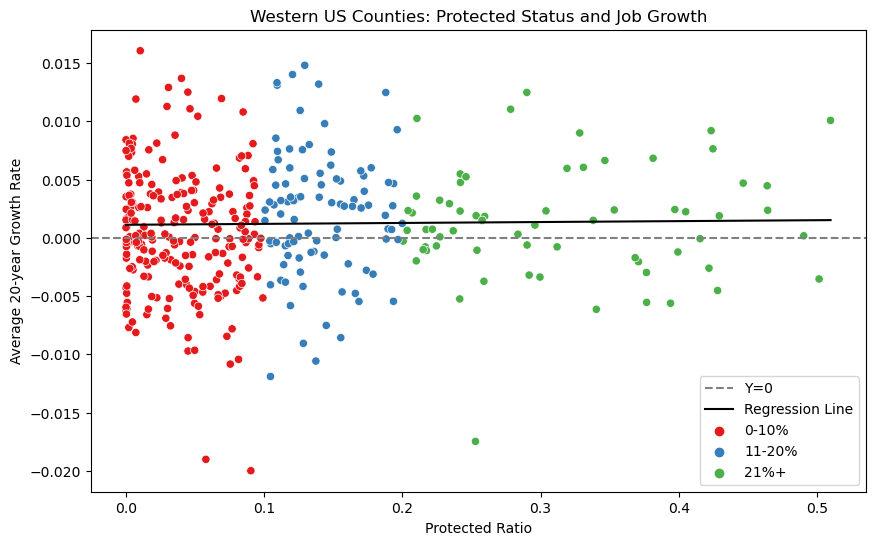

In [19]:
plot_scatter_and_regression(df)